In [1]:
# autoreload
%load_ext autoreload
%autoreload 2
# imports
import numpy as np
from matplotlib import pyplot as plt
from ipywidgets import widgets

import scienceplots
plt.style.use(['science','no-latex'])
# plt.style.use(['science'])


# change matplotlib colrormap
cmap = 'magma'
plt.rcParams['image.cmap'] = cmap

# add src to path
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.path.dirname(''), '..')))
from src.dynamics import dynamics



In [2]:

def response(W, I, B):
    """Compute the linear response of a 3-population network.
    assumes that cellular gains are 1."""

    w_ll, w_le, w_lp = W[0, 0], W[0, 1], - W[0, 2]
    w_el, w_ee, w_ep = W[1, 0], W[1, 1], - W[1, 2]
    w_pl, w_pe, w_pp = W[2, 0], W[2, 1], - W[2, 2]

    dI_l, dI_e, dI_p = I[0], I[1], I[2]

    b_l, b_e, b_p = B[0], B[1], B[2]

    b_inv = np.linalg.inv(np.array([[b_l, 0, 0],
                                    [0, b_e, 0],
                                    [0, 0, b_p]]))
    det = np.linalg.det(b_inv - W)

    if det == 0:
        raise ValueError("The matrix (I - W) is singular, cannot compute response.")
    
    # det = 1
    # R_l = (1/det) * (dI_l*(1 + w_pp - w_ee - w_ee*w_pp + w_ep*w_pe) + dI_e*(w_le + w_le*w_pp - w_lp*w_pe) + dI_p*(- w_lp - w_le*w_ep + w_lp*w_ee))

    # R_e = (1/det) * (dI_l*(w_el + w_el*w_pp - w_ep*w_pl) + dI_e*(1 + w_pp - w_ll - w_ll*w_pp + w_lp*w_pl) + dI_p * (- w_ep - w_el*w_lp + w_ep*w_ll))


    R_ll = (1/det)*((1/b_e - w_ee)*(1/b_p + w_pp) + w_ep*w_pe)
    R_le = (1/det)*(w_le*(1/b_p + w_pp) - w_lp*w_pe)
    R_lp = (1/det)*(- w_le*w_ep - w_lp*(1/b_e - w_ee))

    R_el = (1/det)*(w_el *(1/b_p + w_pp) - w_pl*w_ep)
    R_ee = (1/det)*((1/b_l - w_ll)*(1/b_p + w_pp) + w_lp*w_pl)
    R_ep = (1/det)*(- w_ep*(1/b_l - w_ll) - w_lp*w_el)


    R_l = R_ll*dI_l + R_le*dI_e + R_lp*dI_p
    R_e = R_el*dI_l + R_ee*dI_e + R_ep*dI_p
    

    return R_l, R_e

def response_regime_metric(R_l, R_e):
    """ returns the matrix of response regimes:
    0: both positive
    1: late positive, early negative or zero
    2: late negative or zero, early positive
    """

    regime = np.zeros(R_l.shape)
    regime[(R_l > 0) & (R_e > 0)] = 0
    regime[(R_l > 0) & (R_e <= 0)] = 1
    regime[(R_l <= 0) & (R_e > 0)] = 2
    regime[(R_l < 0) & (R_e < 0)] = 3
    return regime

def response_regime_metric_2(R_l, R_e):
    """ returns the matrix of response regimes:
    0: both positive
    1: late positive, early negative or zero
    2: late negative or zero, early positive
    """


    regime = R_l / R_e

    return regime

In [3]:
def early_vs_late_inhibition_diff_excitability(J, alpha, beta, g, a, b, c, b_l, b_e, b_p):


    W = np.array([[J, J, - alpha*J],
                  [J, J, - beta*J],
                  [J, J, - g*J]])
    
    I = np.array([a, b, c])
    B = np.array([b_l, b_e, b_p])

    R_l, R_e = response(W, I, B)
    return R_l, R_e
    
def plot_response_differential_inh(J, g, a, b, c, b_l, b_e, b_p, density=100, save_fig_location='results/diff_inh_diff_excitability'):
    alpha_arr = np.linspace(0.1, 4.0, density)
    beta_arr = np.linspace(0.1, 4.0, density)

    R_l = np.zeros((len(alpha_arr), len(beta_arr)))
    R_e = np.zeros((len(alpha_arr), len(beta_arr)))

    for alpha_idx, alpha in enumerate(alpha_arr):
        for beta_idx, beta in enumerate(beta_arr):
            R_l[alpha_idx, beta_idx], R_e[alpha_idx, beta_idx] = early_vs_late_inhibition_diff_excitability(J, alpha, beta, g, a, b, c, b_l, b_e, b_p)

    R_eff = response_regime_metric(R_l, R_e)

    fig, ax = plt.subplots(1, 2, figsize=(7, 3), dpi=250)

    vmin = min(np.min(R_l), np.min(R_e))
    vmax = max(np.max(R_l), np.max(R_e))   
    vmin = -1
    vmax = 4
    
    fs = 15
    im1 = ax[0].imshow(R_l, extent=(0.1, 4, 0.1, 4), origin='lower', aspect='auto', vmin=vmin, vmax=vmax)
    
    ax[0].set_title(r"$R_L$")
    ax[0].set_ylabel(r"$\alpha$", fontsize=fs)
    ax[0].set_xlabel(r"$\beta$", fontsize=fs)
    fig.colorbar(im1, ax=ax[0]) 

    # plot a line where R_l = 0 on the im1 plot
    cs = ax[0].contour(alpha_arr, beta_arr, R_l, levels=[0], colors='white', linewidths=1, linestyles='dashed')
    ax[0].clabel(cs, inline=True, fontsize=5, fmt=r"$R_L=0$")

    im2 = ax[1].imshow(R_e, extent=(0.1, 4, 0.1, 4), origin='lower', aspect='auto', vmin=vmin, vmax=vmax)
    ax[1].set_title(r"$R_E$")
    ax[1].set_ylabel(r"$\alpha$", fontsize=fs)
    ax[1].set_xlabel(r"$\beta$", fontsize=fs)
    fig.colorbar(im2, ax=ax[1])

    # plot a line where R_e = 0 on the im2 plot
    cs = ax[1].contour(alpha_arr, beta_arr, R_e, levels=[0], colors='white', linewidths=1, linestyles='dashed')
    ax[1].clabel(cs, inline=True, fontsize=5, fmt=r"$R_E=0$")

    fig.tight_layout()
    fig.savefig(os.path.join(save_fig_location, 'responses_differential_inh.png'), dpi=500)

    fig, ax = plt.subplots(1, 1, figsize=(4, 2.5), dpi=300)
    im = ax.imshow(R_eff, extent=(0.1, 4.0, 0.1, 4.0), origin='lower', aspect='auto')
    ax.set_title('Response Regimes')
    ax.set_ylabel(r"$\alpha$", fontsize=fs)
    ax.set_xlabel(r"$\beta$", fontsize=fs)
    cbar = fig.colorbar(im, ax=ax, ticks=[0, 1, 2])
    cbar.ax.set_yticklabels(['Acquisition', 'Early recall', 'Late recall'])
    fig.tight_layout()
    fig.savefig(os.path.join(save_fig_location, 'response_regimes_differential_inh.png'), dpi=500)
    fig.show()

In [4]:
@widgets.interact(J=widgets.FloatSlider(0.5, min=0, max=2.0, step=0.01), 
                  g=widgets.FloatSlider(0.5, min=0.1, max=1, step=0.01), 
                  a=widgets.FloatSlider(1.0, min=0.0, max=2.0, step=0.1),
                  b=widgets.FloatSlider(1.0, min=0.0, max=2.0, step=0.1), 
                  c=widgets.FloatSlider(1.0, min=0.0, max=2.0, step=0.1),
                  b_l=widgets.FloatSlider(1, min=0.0, max=2.0, step=0.1),
                  b_e=widgets.FloatSlider(1, min=0.0, max=2.0, step=0.1),
                  b_p=widgets.FloatSlider(1, min=0.0, max=2.0, step=0.1),)
def explore_response_differential_inh(J, g, a, b, c, b_l, b_e, b_p):
    """ get the dynamics from the other script and plug in the values"""
    plot_response_differential_inh(J, g, a, b, c, b_l, b_e, b_p, save_fig_location='../results/diff_inh_diff_excitability')
    

interactive(children=(FloatSlider(value=0.5, description='J', max=2.0, step=0.01), FloatSlider(value=0.5, desc…

In [5]:
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False

# set axes ticks off for top and right axes
plt.rcParams['xtick.top'] = False
plt.rcParams['ytick.right'] = False

In [6]:
def plot_dynamics(J, alpha, beta, g, a, b, c, save_fig_location='../results/diff_inh/dynamics.svg', title='Population Dynamics'):
    """ get the dynamics from the other script and plug in the values"""
    W = np.array([[J, J, - alpha*J],
                    [J, J, - beta*J],
                    [J, J, - g*J]])
    I = np.array([a, b, c])

    bg = np.array([1.0, 1.0, 1.0])
    r_l, r_e, r_i, time_arr = dynamics(W, bg, I)
    
    plt.figure(figsize=(3.5, 2), dpi=300)
    plt.plot(time_arr, r_l, label='L', color='C0')
    plt.plot(time_arr, r_e, label='E', color='C1')
    # plt.plot(time_arr, r_i, label='PV', color='C2')

    # set time axis to seconds

    plt.xlabel('Time (sec)')
    plt.ylabel('Firing Rate (Hz)')
    plt.ylim((-0.5, 4))
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.savefig(save_fig_location, dpi=500)
    plt.show()    

In [7]:
@widgets.interact(J=widgets.FloatSlider(0.5, min=0, max=2.0, step=0.01),
                  alpha=widgets.FloatSlider(1.0, min=0.1, max=4.0, step=0.1),
                  beta=widgets.FloatSlider(1.4, min=0.1, max=4.0, step=0.1),
                  g=widgets.FloatSlider(0.5, min=0.1, max=1, step=0.01), 
                  a=widgets.FloatSlider(1.0, min=0.0, max=2.0, step=0.1),
                  b=widgets.FloatSlider(1.0, min=0.0, max=2.0, step=0.1), 
                  c=widgets.FloatSlider(1.0, min=0.0, max=2.0, step=0.1))
def explore_plot_dynamics(J, alpha, beta, g, a, b, c):
    """ get the dynamics from the other script and plug in the values"""
    plot_dynamics(J, alpha, beta, g, a, b, c, save_fig_location='../results/diff_inh/dynamics_differential_inh.svg')
    

interactive(children=(FloatSlider(value=0.5, description='J', max=2.0, step=0.01), FloatSlider(value=1.0, desc…

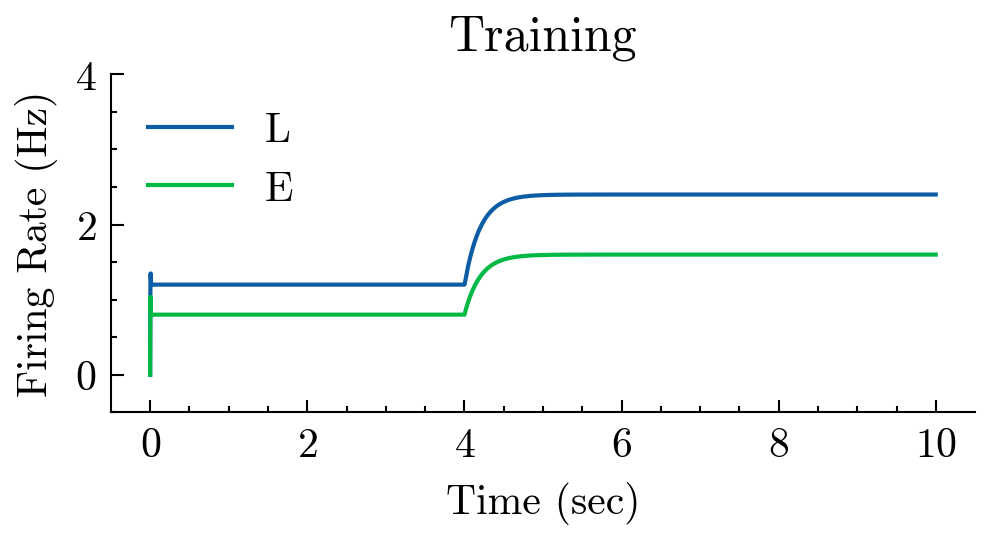

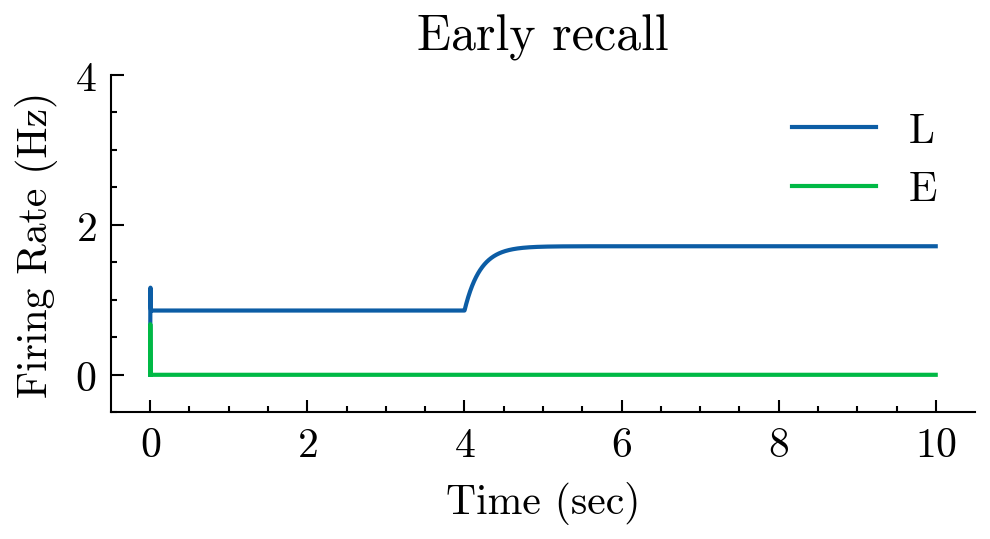

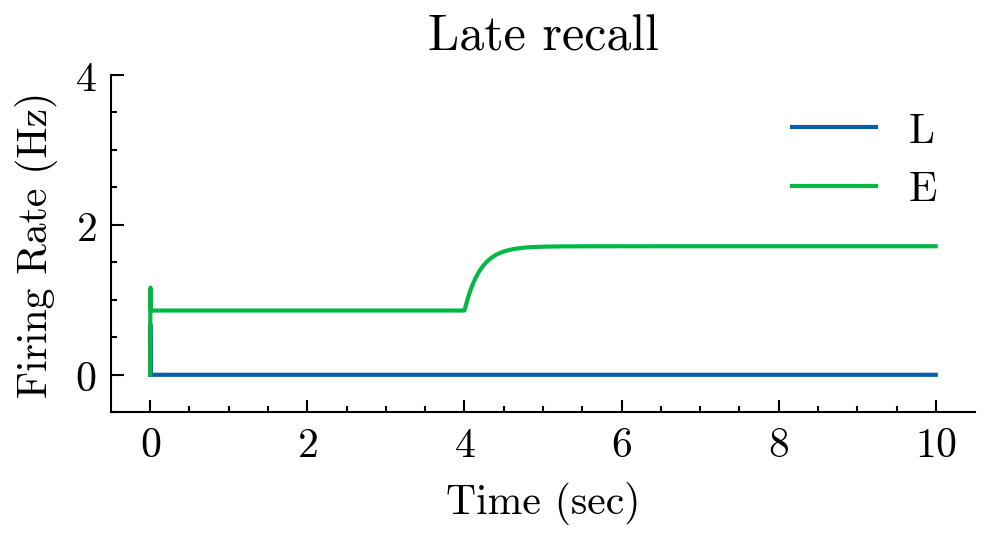

In [8]:
# save figures

J = 0.5
g = 0.5
a = 1.0
b = 1.0
c = 1.0


# trainning
alpha = 1.0
beta = 1.5
plot_dynamics(J, alpha, beta, g, a, b, c, save_fig_location='../results/diff_inh/dynamics_differential_inh_training.svg', title="Training")


# early recall
alpha = 1.0
beta = 2.6
plot_dynamics(J, alpha, beta, g, a, b, c, save_fig_location='../results/diff_inh/dynamics_differential_inh_early_recall.svg', title="Early recall")

# late recall
alpha = 2.6
beta = 1.0
plot_dynamics(J, alpha, beta, g, a, b, c, save_fig_location='../results/diff_inh/dynamics_differential_inh_late_recall.svg', title="Late recall")

In [9]:
@widgets.interact(J=widgets.FloatSlider(0.5, min=0, max=2.0, step=0.01), 
                  g=widgets.FloatSlider(0.5, min=0.1, max=1, step=0.01), 
                  a=widgets.FloatSlider(1.0, min=0.0, max=2.0, step=0.1),
                  b=widgets.FloatSlider(0.5, min=0.0, max=2.0, step=0.1), 
                  c=widgets.FloatSlider(1.0, min=0.0, max=2.0, step=0.1))
def explore_response_differential_inh_diff_input(J, g, a, b, c):
    """ get the dynamics from the other script and plug in the values"""
    plot_response_differential_inh(J, g, a, b, c, density=100, save_fig_location="../results/diff_inh_diff_input")

interactive(children=(FloatSlider(value=0.5, description='J', max=2.0, step=0.01), FloatSlider(value=0.5, desc…

In [10]:
# plot response regimes for different input strengths

# when I_e < I_l
J = 0.5
g = 0.5
a = 1.0
b = 0.5
c = 1.0
plot_response_differential_inh(J, g, a, b, c, density=200, save_fig_location="../results/diff_inh_diff_input")

TypeError: plot_response_differential_inh() missing 3 required positional arguments: 'b_l', 'b_e', and 'b_p'

In [ ]:
def early_vs_late_inh_diff_assem_weights(J, g, alpha, beta, w, a, b, c):

    W = np.array([[w*J, J, - alpha*J],
                  [J, w*J, - beta*J],
                  [J, J, - g*J]])
    
    I = np.array([a, b, c])

    R_l, R_e = response(W, I)

    return R_l, R_e


In [ ]:
@widgets.interact(J=widgets.FloatSlider(0.5, min=0.0, max=2.0, step=0.01), 
                  g=widgets.FloatSlider(0.5, min=0.1, max=1.0, step=0.01), 
                  w=widgets.FloatSlider(1.1, min=1.0, max=2.0, step=0.1),
                  a=widgets.FloatSlider(1.0, min=0.0, max=2.0, step=0.1),
                  b=widgets.FloatSlider(1.0, min=0.0, max=2.0, step=0.1), 
                  c=widgets.FloatSlider(1.0, min=0.0, max=2.0, step=0.1))
def plot_response_assem_weights(J, g, w, a, b, c):
    alpha_arr = np.linspace(0.1, 4.0, 100)
    beta_arr = np.linspace(0.1, 4.0, 100)

    R_l = np.zeros((len(alpha_arr), len(beta_arr)))
    R_e = np.zeros((len(alpha_arr), len(beta_arr)))

    for alpha_idx, alpha in enumerate(alpha_arr):
        for beta_idx, beta in enumerate(beta_arr):
            R_l[alpha_idx, beta_idx], R_e[alpha_idx, beta_idx] = early_vs_late_inh_diff_assem_weights(J, g, alpha, beta, w, a, b, c)
    
    R_eff = np.zeros_like(R_l)
    R_eff[(R_l > 0) & (R_e > 0)] = 0
    R_eff[(R_l > 0) & (R_e <= 0)] = 1
    R_eff[(R_l <= 0) & (R_e > 0)] = 2

    # print(R_l)
    # print(R_e)
    # print(R_eff)

    fig, ax = plt.subplots(1, 2, figsize=(9, 4), dpi=200)

    vmin = -3
    vmax = 3
    im1 = ax[0].imshow(R_l, extent=(0.1, 4, 0.1, 4), origin='lower', aspect='auto', vmin=vmin, vmax=vmax)
    ax[0].set_title('R_l')
    ax[0].set_ylabel('Alpha (Late Inhibition Strength)')
    ax[0].set_xlabel('Beta (Early Inhibition Strength)')
    
    cs = ax[0].contour(alpha_arr, beta_arr, R_l, levels=[0], colors='white', linewidths=1, linestyles='dashed')
    ax[0].clabel(cs, inline=True, fontsize=5, fmt=r"$R_L=0$")

    #

    fig.colorbar(im1, ax=ax[0]) 

    im2 = ax[1].imshow(R_e, extent=(0.1, 4, 0.1, 4), origin='lower', aspect='auto', vmin=vmin, vmax=vmax)
    ax[1].set_title('R_e')
    ax[1].set_ylabel('Alpha (Late Inhibition Strength)')
    ax[1].set_xlabel('Beta (Early Inhibition Strength)')
    fig.colorbar(im2, ax=ax[1])

    fig.suptitle("Differential inhibitory connectivity, strong within assembly weights")
    fig.tight_layout()


    fig, ax = plt.subplots(1, 1, figsize=(4, 2.5), dpi=300)
    im = ax.imshow(R_eff, extent=(0.1, 4.0, 0.1, 4.0), origin='lower', aspect='auto')
    ax.set_title('Response Regimes')
    ax.set_ylabel(r"$\alpha$")
    ax.set_xlabel(r"$\beta$")
    cbar = fig.colorbar(im, ax=ax, ticks=[0, 1, 2])
    cbar.ax.set_yticklabels(['Acquisition', 'Early recall', 'Late recall'])
    fig.tight_layout()
    # fig.savefig('response_regimes.png', dpi=500)
    fig.show()

interactive(children=(FloatSlider(value=0.5, description='J', max=2.0, step=0.01), FloatSlider(value=0.5, desc…